In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import seaborn as sns

In [2]:
class GraphConvolution(nn.Module):
    def __init__(self,input_dim,output_dim,use_bias=True):
        super(GraphConvolution,self).__init__()
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.use_bias=use_bias
        self.weight=nn.Parameter(torch.Tensor(input_dim,output_dim))
        if self.use_bias:
            self.bias=nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter("bias",None)
        self.reset_parameters()
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)
    def forward(self,adjacency,input_feature):
        support=torch.mm(input_feature,self.weight)
        output=torch.sparse.mm(adjacency,support)
        if self.use_bias:
            output+=self.bias
        return output
    def __repr__(self):
        return self.__class__.__name__+'('+str(self.input_dim)+' -> '+str(self.output_dim)+')'

In [3]:
graphConv=GraphConvolution(5,4)
graphConv.reset_parameters()
print(graphConv.weight)
print(graphConv.bias)
print(graphConv.__repr__())

Parameter containing:
tensor([[ 1.0170, -0.9956, -0.1809, -0.1171],
        [ 0.7921,  0.5699,  0.0460, -0.1756],
        [ 1.1232, -0.4016, -0.1528, -0.3239],
        [-0.0764,  0.5068,  0.2771, -0.8594],
        [ 0.2348,  0.2136, -0.0886,  0.6545]], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)
GraphConvolution(5 -> 4)


In [4]:
class GCN(nn.Module):
    def __init__(self,input_dim):
        super(GCN,self).__init__()
        self.gcn1=GraphConvolution(input_dim,128)
        self.gcn2=GraphConvolution(128,7)        
    def forward(self,adjacency,feature):
        h=F.relu(self.gcn1(adjacency,feature))
        logits=F.softmax(self.gcn2(adjacency,h),dim=-1)
        return logits

In [5]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [6]:
from dataset import CoraData

In [103]:
#hyper params
LEARNING_RATE=0.005
WEIGHT_DECAY=1e-4
EPOCHS=200
INPUT_DIM=1433
device="cuda:0" if torch.cuda.is_available() else "cpu"
Data=namedtuple('Data',['x','y','adjacency','train_mask','val_mask','test_mask'])

In [104]:
dataset=CoraData(rebuild=True).data
node_feature=dataset.x/dataset.x.sum(axis=1,keepdims=True)
tensor_x=torch.from_numpy(node_feature).to(device)
tensor_y=torch.from_numpy(dataset.y).to(device)
#训练集-评估集-测试集
tensor_train_mask=torch.from_numpy(dataset.train_mask).to(device)
tensor_val_mask=torch.from_numpy(dataset.val_mask).to(device)
tensor_test_mask=torch.from_numpy(dataset.test_mask).to(device)
#规范化邻接矩阵
normalize_adjacency=CoraData.normalization(dataset.adjacency)

Process data ...
Node's feature shape:  (2708, 1433)
Node's label shape:  (2708,)
Adjacency's shape:  (2708, 2708)
Number of training nodes:  140
Number of validation nodes:  500
Number of test nodes:  1000
Cached file: ../dataset/cora\processed_cora.pkl


In [105]:
num_nodes,input_dim=node_feature.shape
print(normalize_adjacency)
indices=torch.from_numpy(np.asarray([normalize_adjacency.row,normalize_adjacency.col]).astype('int64')).long()
print(normalize_adjacency.row)
print(normalize_adjacency.col)
print(indices)
values=torch.from_numpy(normalize_adjacency.data.astype(np.float32))
print(normalize_adjacency.data)
print(values)
tensor_adjacency=torch.sparse.FloatTensor(indices,values,(num_nodes,num_nodes)).to(device)
print(tensor_adjacency)

  (0, 0)	0.25
  (0, 633)	0.25
  (0, 1862)	0.22360679774997896
  (0, 2582)	0.25
  (1, 1)	0.25
  (1, 2)	0.2041241452319315
  (1, 652)	0.28867513459481287
  (1, 654)	0.3535533905932738
  (2, 1)	0.2041241452319315
  (2, 2)	0.16666666666666666
  (2, 332)	0.16666666666666666
  (2, 1454)	0.2886751345948129
  (2, 1666)	0.1543033499620919
  (2, 1986)	0.050251890762960605
  (3, 3)	0.5000000000000001
  (3, 2544)	0.5000000000000001
  (4, 4)	0.16666666666666666
  (4, 1016)	0.16666666666666666
  (4, 1256)	0.13608276348795434
  (4, 1761)	0.14433756729740646
  (4, 2175)	0.16666666666666666
  (4, 2176)	0.13608276348795434
  (5, 5)	0.25
  (5, 1629)	0.25
  (5, 1659)	0.28867513459481287
  :	:
  (2699, 2699)	0.5000000000000001
  (2700, 1151)	0.408248290463863
  (2700, 2700)	0.5000000000000001
  (2701, 44)	0.28867513459481287
  (2701, 2624)	0.3333333333333333
  (2701, 2701)	0.3333333333333333
  (2702, 186)	0.2182178902359924
  (2702, 1536)	0.2581988897471611
  (2702, 2702)	0.3333333333333333
  (2703, 1298)	

In [106]:
model=GCN(input_dim=INPUT_DIM).to(device)
criterion=nn.CrossEntropyLoss().to(device)
optimizer=optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)

In [107]:
def train():
    model.train()
    global tensor_adjacency
    train_loss_history=[]
    train_acc_history=[]
    val_loss_history=[]
    val_acc_history=[]
    train_y=tensor_y[tensor_train_mask]
    for epoch in range(EPOCHS):
        logits=model(tensor_adjacency,tensor_x)
        train_mask_logits=logits[tensor_train_mask]
        loss=criterion(train_mask_logits,train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc,_,_,train_loss=test(tensor_train_mask,tensor_y)
        val_acc,_,_,val_loss=test(tensor_val_mask,tensor_y)
        train_loss_history.append(loss.item())
        train_acc_history.append(train_acc.item())
        val_loss_history.append(val_loss.item())
        val_acc_history.append(val_acc.item())
        print("epoch {:02}:train loss {:.4f},train accuracy:{:.4f},validation accuracy:{:.4f}"
              .format(epoch,loss.item(),train_acc.item(),val_acc.item()))
    return train_loss_history,train_acc_history,val_loss_history,val_acc_history

In [108]:
def test(mask,y):
    model.eval()
    with torch.no_grad():
        logits=model(tensor_adjacency,tensor_x)
        test_mask_logits=logits[mask]
        loss=criterion(test_mask_logits,y[mask])
        predict_y=test_mask_logits.max(1)[1]
        accuracy=torch.eq(predict_y,tensor_y[mask]).float().mean()
    return accuracy,test_mask_logits.cpu().numpy(),tensor_y[mask].cpu().numpy(),loss

In [109]:
def plot_loss_with_acc(train_loss_history,train_acc_history,val_loss_history,val_acc_history):
    plt.figure(figsize=(12,8))
    plt.plot(range(len(train_loss_history)),train_loss_history,label="training loss")
    plt.plot(range(len(val_loss_history)),val_loss_history,label="validation loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend(loc=0)
    plt.title("loss fig")
    plt.savefig("loss.png",dpi=1000)
    plt.show()
    
    plt.figure(figsize=(12,8))
    plt.plot(range(len(train_acc_history)),train_acc_history,label="training accuracy")
    plt.plot(range(len(val_acc_history)),val_acc_history,label="validation accuracy")
    plt.xlabel("epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc=0)
    plt.title("accuracy fig")
    plt.savefig("accuracy.png",dpi=1000)
    plt.show()

epoch 00:train loss 1.9455,train accuracy:0.4571,validation accuracy:0.3880
epoch 01:train loss 1.9373,train accuracy:0.6500,validation accuracy:0.5220
epoch 02:train loss 1.9291,train accuracy:0.7571,validation accuracy:0.5620
epoch 03:train loss 1.9204,train accuracy:0.8071,validation accuracy:0.5880
epoch 04:train loss 1.9108,train accuracy:0.8357,validation accuracy:0.5980
epoch 05:train loss 1.8999,train accuracy:0.8786,validation accuracy:0.6100
epoch 06:train loss 1.8876,train accuracy:0.8929,validation accuracy:0.6260
epoch 07:train loss 1.8738,train accuracy:0.8929,validation accuracy:0.6220
epoch 08:train loss 1.8587,train accuracy:0.8929,validation accuracy:0.6400
epoch 09:train loss 1.8423,train accuracy:0.8857,validation accuracy:0.6380
epoch 10:train loss 1.8246,train accuracy:0.9071,validation accuracy:0.6520
epoch 11:train loss 1.8057,train accuracy:0.9143,validation accuracy:0.6660
epoch 12:train loss 1.7856,train accuracy:0.9214,validation accuracy:0.6820
epoch 13:tra

epoch 116:train loss 1.2053,train accuracy:1.0000,validation accuracy:0.7920
epoch 117:train loss 1.2050,train accuracy:1.0000,validation accuracy:0.7920
epoch 118:train loss 1.2048,train accuracy:1.0000,validation accuracy:0.7920
epoch 119:train loss 1.2045,train accuracy:1.0000,validation accuracy:0.7920
epoch 120:train loss 1.2043,train accuracy:1.0000,validation accuracy:0.7900
epoch 121:train loss 1.2041,train accuracy:1.0000,validation accuracy:0.7900
epoch 122:train loss 1.2038,train accuracy:1.0000,validation accuracy:0.7900
epoch 123:train loss 1.2036,train accuracy:1.0000,validation accuracy:0.7900
epoch 124:train loss 1.2034,train accuracy:1.0000,validation accuracy:0.7880
epoch 125:train loss 1.2032,train accuracy:1.0000,validation accuracy:0.7880
epoch 126:train loss 1.2030,train accuracy:1.0000,validation accuracy:0.7880
epoch 127:train loss 1.2028,train accuracy:1.0000,validation accuracy:0.7880
epoch 128:train loss 1.2027,train accuracy:1.0000,validation accuracy:0.7880

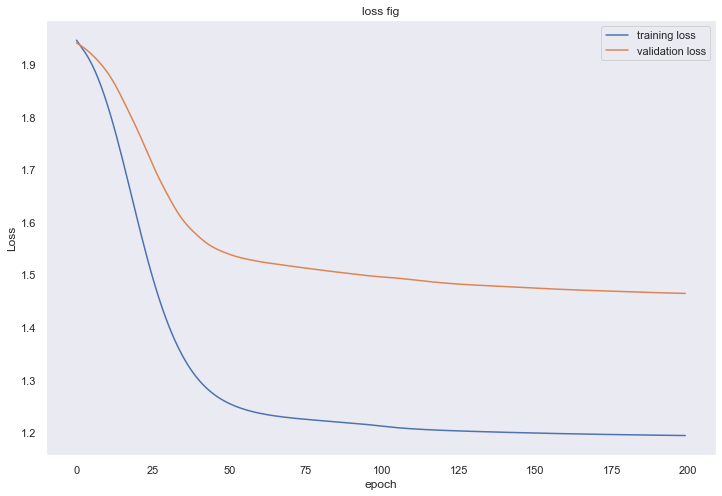

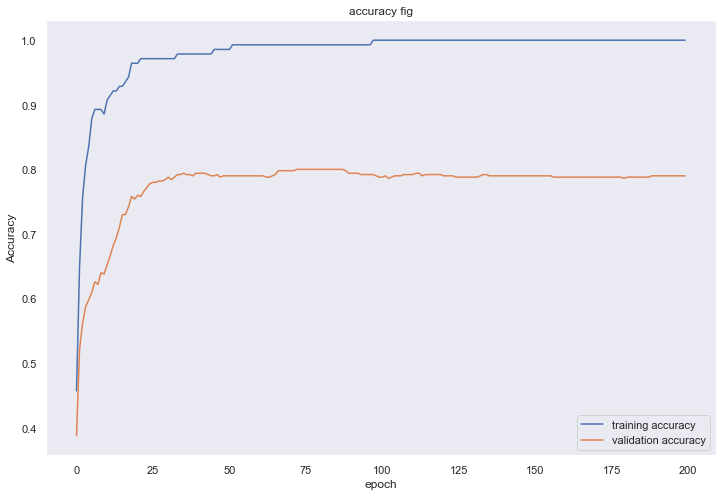

In [110]:
train_loss,train_acc,val_loss,val_acc=train()
test_acc,test_logits,test_label,_=test(tensor_test_mask,tensor_y)
print("test accuracy:",test_acc.item())
plot_loss_with_acc(train_loss,train_acc,val_loss,val_acc)

In [166]:
def plot_classification():
    sns.set(style='dark')
    # tsne visualize
    tsne = TSNE()
    out = tsne.fit_transform(test_logits)
    fig = plt.figure(figsize=(8,6))    
    basic=0
    namelist=['Case based','Genetic Algorithms','Neural Networks','Probabilistic methods','Reinforcement learning','Rule-based learning','Theories']
    for i in range(7):
        basic+=20
        indices = test_label == i
        x, y = out[indices].T
        #sns.scatterplot(x, y,size=i,sizes=(20+40*i+pow(3,i),500),marker="o",alpha=0.6,label=namelist[i],legend=None,palette="Set3")
        sns.scatterplot(x, y,size=1000,marker="o",alpha=0.8,label=namelist[i],legend=None,palette="Set3")
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.title("CoraClassification")
    plt.savefig('tsne.png',dpi=1000)
    plt.show()

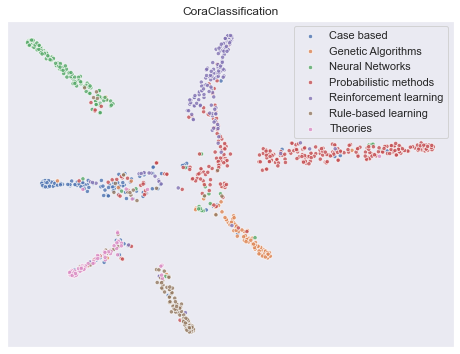

In [167]:
plot_classification()